In [520]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Wetter- und Luftqualitätsdaten") \
    .getOrCreate()

<div style="background-color:#add8e6; height:50px; border-radius:10px; text-align:center; padding-top:5px;">
  <strong style="color:#003366; font-size: 20px;">Vorbereitung des Machine Learnings</strong>
</div>


# Big Data Leistungsnachweis
<br>
Wie beeinflusst das Wetter die Luftqualität?“ – Vergleich zwischen Zürich und St. Gallen mit Spark MLlib

In [521]:
#Kurzes Prüfen, ob man im korrekten Directory unterwegs ist und die Files sichtbar sind
import os
os.listdir(".")  # Liste der Files im Working Directory


['.DS_Store',
 '.git',
 '.idea',
 '.ipynb_checkpoints',
 '.jupyter',
 '01_LoadData.ipynb',
 '02_ML.ipynb',
 '03_Visualisation.ipynb',
 'data',
 'README.md']

## ML Pipelines
<br>
ML-Pipelines dienen der Reproduzierbarkeit eines ML-Verfahrens (und hilft beim Erstellen einer sauberen Struktur) und bestehen gemäss Spark-Dokumentation (https://spark.apache.org/docs/latest/ml-pipeline.html) aus folgenden Elementen:
<br><br>
<b>Transformers</b> <br> <br>
<b>Estimators</b>
<br> <br>
Ein Transformer konvertiert DataFrames. Ein "Feature Transformer" liest beispielsweise die Daten einer Spalte, mappt diese in eine neue Spalte und gibt als Output das als DataFrame.
<br>
Ein "Learning Model" hingegen lernt aus einem DataFrame und predictet etwas, welches es als DataFrame wiederum dann ausgeben kann.
<br>
Ein Estimator implementiert eine fit()-Methode, welhe ein DataFrame nimmt und ein Model produziert (=Transformer).
<br>
<br>
Eine Pipeline ist eine Sequenz an Phasen bestehend aus Transformern und Estimatorn. BEim Durchlaufen der "Stages" wird ein DataFrame entsprechend verarbeitet.

In [522]:
df = spark.read.option("header", True) \
                .option("delimiter", ",") \
                .csv("data/cleaned/cleaned_Data.csv")


In [523]:
df = df.withColumnRenamed("PM2.5", "PM2_5")
df.show()

+----------+--------+-----+-----+----+-----+-----+----+-------------------------------------------+----------------------------------------------+----------------------------------------------+----------------------------------------------+-------------------------------------------------+-------------------------------------------------+-------------------------------------------------+-------------------------------------------+------------------------------------------------------------+----------------------------------------------+---------------------------------------------------+---------------------------------------------------+-------------------------------------------------------------------------------+-----------------------------------+-------------------------------------------+------------------------------------+--------------------------------------------+----------------------------------------------+-----------------------------------------------+-----------------

## Feature-Vektor erstellen
ML-Algorithmen erwarten meistens die Daten zusammen in einem Feature-Vektor.

In [524]:
#Wir wollen auch kurz prüfen, ob das geklappt hat und Einträge für beide Städte vorhanden sind
df.select("location").distinct().show()
#korrekter Output wäre stadt zh sg in einer kleinen TAbelle

+----------+
|  location|
+----------+
|St. Gallen|
|    Zürich|
+----------+



Zum Erstellen eines Feature-Vektors müssen wir die Feature-Spalten auswählen. Dabei handelt es sich um die numerischen Werte (diese können wir nachher auch standardisieren). Wegzulassen sind dabei in umserem FAll die Zeitstempel als auch die Information zur Stadt.

In [525]:
df.printSchema()
#BEim Printen des Schemas zeigt sich, dass alle COlumns noch als String interpretiert werden, darum funktioniert dabei assembler.transform nicht
#Wir müssen also zuerst die Strings umwandeln

root
 |-- date: string (nullable = true)
 |-- location: string (nullable = true)
 |-- PM10: string (nullable = true)
 |-- PM2_5: string (nullable = true)
 |-- Ozon: string (nullable = true)
 |-- CO: string (nullable = true)
 |-- NO2: string (nullable = true)
 |-- NO: string (nullable = true)
 |-- Air temperature 2 m above ground daily mean: string (nullable = true)
 |-- Air temperature 2 m above ground daily maximum: string (nullable = true)
 |-- Air temperature 2 m above ground daily minimum: string (nullable = true)
 |-- Air temperature at 5 cm above grass daily mean: string (nullable = true)
 |-- Air temperature at 5 cm above grass daily maximum: string (nullable = true)
 |-- Air temperature at 5 cm above grass daily minimum: string (nullable = true)
 |-- Relative air humidity 2 m above ground daily mean: string (nullable = true)
 |-- Vapour pressure 2 m above ground daily mean: string (nullable = true)
 |-- Atmospheric pressure at barometric altitude (QFE) daily mean: string (nulla

In [526]:
umweltfaktoren = ["PM10", "PM2_5", "Ozon", "CO", "NO2", "NO", "Air temperature 2 m above ground daily mean", "Relative air humidity 2 m above ground daily mean", "Wind speed scalar daily mean in m/s","Precipitation daily total 0 UTC - 0 UTC"]
for c in umweltfaktoren:
    if c not in df.columns:
        print(f"Spalte nicht gefunden, wg. NAmensproblem: '{c}'")
    else: 
        print(f"Spalte '{c}'vorhanden")


Spalte 'PM10'vorhanden
Spalte 'PM2_5'vorhanden
Spalte 'Ozon'vorhanden
Spalte 'CO'vorhanden
Spalte 'NO2'vorhanden
Spalte 'NO'vorhanden
Spalte 'Air temperature 2 m above ground daily mean'vorhanden
Spalte 'Relative air humidity 2 m above ground daily mean'vorhanden
Spalte 'Wind speed scalar daily mean in m/s'vorhanden
Spalte 'Precipitation daily total 0 UTC - 0 UTC'vorhanden


In [527]:
from pyspark.sql.functions import col, regexp_replace


for c in umweltfaktoren: #hier noch eine Vorsichtsmassnahme, indem allfällige Kommas zu Punkten für Dezimaldarstellung ugmwandelt werden
    df = df.withColumn(c, regexp_replace(col(c), ",", ".").cast("double"))


In [528]:
from pyspark.sql.functions import col
cnv_list = ["PM10", "PM2_5", "Ozon", "CO", "NO2", "NO", "Air temperature 2 m above ground daily mean", "Relative air humidity 2 m above ground daily mean", "Wind speed scalar daily mean in m/s","Precipitation daily total 0 UTC - 0 UTC"]

for col_name in cnv_list:
    df = df.withColumn(col_name, col(col_name).cast("float"))

In [529]:
from pyspark.ml.feature import VectorAssembler

umweltfaktoren = ["PM10", "PM2_5", "Ozon", "CO", "NO2", "NO", "Air temperature 2 m above ground daily mean", "Relative air humidity 2 m above ground daily mean", "Wind speed scalar daily mean in m/s","Precipitation daily total 0 UTC - 0 UTC"]

assembler = VectorAssembler(inputCols=umweltfaktoren, outputCol="rawFeatures")
df_vector = assembler.transform(df).dropna(subset=["rawFeatures"])


In [530]:
df_vector.select(umweltfaktoren).printSchema()
#Sind wirklich alle nun Doubles und keine Strings? Wichtig für weitere ARbeit

root
 |-- PM10: float (nullable = true)
 |-- PM2_5: float (nullable = true)
 |-- Ozon: float (nullable = true)
 |-- CO: float (nullable = true)
 |-- NO2: float (nullable = true)
 |-- NO: float (nullable = true)
 |-- Air temperature 2 m above ground daily mean: float (nullable = true)
 |-- Relative air humidity 2 m above ground daily mean: float (nullable = true)
 |-- Wind speed scalar daily mean in m/s: float (nullable = true)
 |-- Precipitation daily total 0 UTC - 0 UTC: float (nullable = true)



In [531]:
df.select(umweltfaktoren).summary().show() #Kurzer Blick auf die SPalten, ggf fällt hier noch etwas auf


+-------+------------------+------------------+-----------------+-----------------+------------------+------------------+-------------------------------------------+-------------------------------------------------+-----------------------------------+---------------------------------------+
|summary|              PM10|             PM2_5|             Ozon|               CO|               NO2|                NO|Air temperature 2 m above ground daily mean|Relative air humidity 2 m above ground daily mean|Wind speed scalar daily mean in m/s|Precipitation daily total 0 UTC - 0 UTC|
+-------+------------------+------------------+-----------------+-----------------+------------------+------------------+-------------------------------------------+-------------------------------------------------+-----------------------------------+---------------------------------------+
|  count|              3613|              3613|             1809|             1781|              3593|              1811|   

In [532]:
from pyspark.sql.functions import isnan

df.select([
    col(c).isNull().alias(f"{c}_null") |
    isnan(c).alias(f"{c}_nan") for c in umweltfaktoren
]).show()


+--------------------------------------------------------+------------------------------------------------------------+--------------------------------------------------------+------------------------------------------------+----------------------------------------------------+------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------

### Ungültige Werte
Bevor wir weiterarbeiten müssen wir wissen, ob wir Rows mit falschen Werten droppen oder ob wir die Werte besser einfüllen (Ersteres ist nur dann geeignet, wenn nicht viele betroffen sind).

In [533]:
df.filter("PM10 is null OR `PM2_5` is null OR Ozon is null OR CO is null OR NO2 is null OR NO is null Or `Air temperature 2 m above ground daily mean` is null OR `Relative air humidity 2 m above ground daily mean` is null OR `Wind speed scalar daily mean in m/s` is null OR `Precipitation daily total 0 UTC - 0 UTC` is null").count()


3620

In [534]:
total = df.count()

fehlend = df.filter(
    "PM10 is null OR `PM2_5` is null OR Ozon is null OR CO is null OR NO2 is null OR NO is null"
).count()

print(f"Fehlend {fehlend} von total {total} Rows ({(fehlend/total)*100:.2f}%)")


Fehlend 3620 von total 3620 Rows (100.00%)


In [535]:
from pyspark.sql.functions import count, when, col, isnan

df.select([
    count(when(col(c).isNull() | isnan(c), c)).alias(f"{c}_missing") for c in umweltfaktoren
]).show()
#Hier stellt sich leider heraus, dass wir etliche fehlende Werte zu haben scheinen
#U.a. haben wir z.B. bei Ozon alleine 1980 und bei CO 2008 oder bei NO 1978 fehlende WErte

+------------+-------------+------------+----------+-----------+----------+---------------------------------------------------+---------------------------------------------------------+-------------------------------------------+-----------------------------------------------+
|PM10_missing|PM2_5_missing|Ozon_missing|CO_missing|NO2_missing|NO_missing|Air temperature 2 m above ground daily mean_missing|Relative air humidity 2 m above ground daily mean_missing|Wind speed scalar daily mean in m/s_missing|Precipitation daily total 0 UTC - 0 UTC_missing|
+------------+-------------+------------+----------+-----------+----------+---------------------------------------------------+---------------------------------------------------------+-------------------------------------------+-----------------------------------------------+
|           7|            7|        1811|      1839|         27|      1809|                                                  0|                                       

Wir wollen nicht alle Rows wegwerfen, die fehlende WErte haben...aber es wäre auch sinnlos, diese mit Nullen zu befüllen, da es sich um so viele Rows handelt.
<br>
Wir wollen die Information speichern, dass hier Werte fehlen. Das können wir, indem wir eine neue Spalte erstellen, in der wir diese Information speichern (binär). 
<br>
Wir erstellen also eine Spalte für Ozon_fehlend, CO_fehlend und NO_fehlend und befüllen dies jeweils mit 0 bzw. 1 (Letzteres für fehlende Werte). D.h. 0 = Wert vorhanden, 1 = Wert fehlt.
<br>
Die anderen drei Spalten mit 13 oder 31 fehlenden Werten droppen wir, da es sich um eine kleine Anzahl handelt.

In [536]:
#Droppen der Reihen mit fehlenden Werten für PM10, PM2_5 und NO2
cols_to_drop_on = ["PM10", "PM2_5", "NO2", "Air temperature 2 m above ground daily mean", "Relative air humidity 2 m above ground daily mean", "Wind speed scalar daily mean in m/s", "Precipitation daily total 0 UTC - 0 UTC"]

df_cleaned = df.dropna(subset=cols_to_drop_on)


In [537]:
#Wir prüfen, ob das geklappt hat und jetzt jeweils 0 bei den Spalten steht
from pyspark.sql.functions import count, when, col, isnan

df_cleaned.select([
    count(when(col(c).isNull() | isnan(c), c)).alias(f"{c}_missing") for c in umweltfaktoren
]).show()

+------------+-------------+------------+----------+-----------+----------+---------------------------------------------------+---------------------------------------------------------+-------------------------------------------+-----------------------------------------------+
|PM10_missing|PM2_5_missing|Ozon_missing|CO_missing|NO2_missing|NO_missing|Air temperature 2 m above ground daily mean_missing|Relative air humidity 2 m above ground daily mean_missing|Wind speed scalar daily mean in m/s_missing|Precipitation daily total 0 UTC - 0 UTC_missing|
+------------+-------------+------------+----------+-----------+----------+---------------------------------------------------+---------------------------------------------------------+-------------------------------------------+-----------------------------------------------+
|           0|            0|        1777|      1810|          0|      1777|                                                  0|                                       

In [538]:
#im nächsten Schritt werden wir sep. Spalten zum Erhalten der Information zu den fehlenden WErten erstellen
#das ändert zwar nichts daran, dass wir die Felder irgendwie befüllen müssen, erhält aber die Information, dass der Wert gefhelt hatte
from pyspark.sql.functions import when, col

cols_to_flag = ["Ozon", "CO", "NO"]

for c in cols_to_flag:
    df_cleaned = df_cleaned.withColumn(f"{c}_missing", when(col(c).isNull(), 1).otherwise(0))


In [539]:
df_cleaned.select("Ozon", "Ozon_missing", "CO", "CO_missing", "NO", "NO_missing").show(10)
#Wir prüfen kurz, ob das geklappt hat und wir nun jeweils dazu passende "_missing"-Spalten haben mit 1 und 0

+----+------------+-----+----------+----+----------+
|Ozon|Ozon_missing|   CO|CO_missing|  NO|NO_missing|
+----+------------+-----+----------+----+----------+
|null|           1|21.11|         0|null|         1|
|null|           1| 26.5|         0|null|         1|
|null|           1|36.66|         0|null|         1|
|null|           1|35.72|         0|null|         1|
|null|           1|28.78|         0|null|         1|
|null|           1|31.55|         0|null|         1|
|null|           1|30.09|         0|null|         1|
|null|           1| 35.4|         0|null|         1|
|null|           1|40.12|         0|null|         1|
|null|           1|35.56|         0|null|         1|
+----+------------+-----+----------+----+----------+
only showing top 10 rows



Nun dürfen wir nicht vergessen, dass wir dennoch die empty Felder mit etwas befüllen müssen.
Wir wählen mal 0 als Wert, da es uns fast schon zu sehr an Einträgen fehlt, um einen MEdian oder ÄHnliches zu berechnen.

In [540]:
df_cleaned = df_cleaned.fillna({
    "CO": 0,
    "Ozon": 0,
    "NO": 0
})
#überall wo na ist, wird eine 0 eingefügt

In [541]:
#neu sollten wir hier also überall 0 als Wert für die Anzahl an NA-Werten erhalten
from pyspark.sql.functions import count, when, col, isnan

df_cleaned.select([
    count(when(col(c).isNull() | isnan(c), c)).alias(f"{c}_missing") for c in umweltfaktoren
]).show()

+------------+-------------+------------+----------+-----------+----------+---------------------------------------------------+---------------------------------------------------------+-------------------------------------------+-----------------------------------------------+
|PM10_missing|PM2_5_missing|Ozon_missing|CO_missing|NO2_missing|NO_missing|Air temperature 2 m above ground daily mean_missing|Relative air humidity 2 m above ground daily mean_missing|Wind speed scalar daily mean in m/s_missing|Precipitation daily total 0 UTC - 0 UTC_missing|
+------------+-------------+------------+----------+-----------+----------+---------------------------------------------------+---------------------------------------------------------+-------------------------------------------+-----------------------------------------------+
|           0|            0|           0|         0|          0|         0|                                                  0|                                       

### Zeiten als Features extrahieren




In [542]:
from pyspark.sql.functions import year, month, dayofmonth, dayofweek, hour

df_cleaned = df_cleaned.withColumn("year_s", year("date")) \
                 .withColumn("month_s", month("date")) \
                 .withColumn("day_s", dayofmonth("date")) \
                 .withColumn("weekday_s", dayofweek("date")) \
                 .withColumn("hour_s", hour("date"))



In [543]:
#Spalten-Preview nach Zeiten-Extraktion
df_cleaned.select("date", "year_s", "month_s", "day_s", "weekday_s", "hour_S").show(10, truncate=False)


+----------+------+-------+-----+---------+------+
|date      |year_s|month_s|day_s|weekday_s|hour_S|
+----------+------+-------+-----+---------+------+
|2020-01-02|2020  |1      |2    |5        |0     |
|2020-01-03|2020  |1      |3    |6        |0     |
|2020-01-04|2020  |1      |4    |7        |0     |
|2020-01-05|2020  |1      |5    |1        |0     |
|2020-01-06|2020  |1      |6    |2        |0     |
|2020-01-07|2020  |1      |7    |3        |0     |
|2020-01-08|2020  |1      |8    |4        |0     |
|2020-01-09|2020  |1      |9    |5        |0     |
|2020-01-10|2020  |1      |10   |6        |0     |
|2020-01-11|2020  |1      |11   |7        |0     |
+----------+------+-------+-----+---------+------+
only showing top 10 rows



#### VEktor erstellen


In [544]:
#wir definieren, welche Spalten wir gerne als Features hätten 
#numerische Spalten als Features, keine Strings oder Timestamps
feature_cols = ["PM10", "PM2_5", "Ozon", "CO", "NO2", "NO", "Ozon_missing", "CO_missing", "NO_missing", "year_s", "month_s", "day_s", "weekday_s", "hour_s", "Air temperature 2 m above ground daily mean", "Relative air humidity 2 m above ground daily mean", "Wind speed scalar daily mean in m/s","Precipitation daily total 0 UTC - 0 UTC"]


In [545]:
#Feature-Vektor erstellen mit VectorAssembler
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_vector = assembler.transform(df_cleaned)  # NAme des aktuellen DataFrames ist df_cleaned

In [546]:
df_vector.select("Ozon_missing", "CO_missing", "NO_missing").printSchema()


root
 |-- Ozon_missing: integer (nullable = false)
 |-- CO_missing: integer (nullable = false)
 |-- NO_missing: integer (nullable = false)



In [547]:
#Vorschau, ob das geklappt hat mit dem Feature-Vektor
df_vector.select("features").show(5, truncate=False)


+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                                                                           |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[16.209999084472656,18.43000030517578,0.0,21.110000610351562,18.8700008392334,0.0,1.0,0.0,1.0,2020.0,1.0,2.0,5.0,0.0,-1.2000000476837158,94.5999984741211,1.0,0.0]                 |
|[16.90999984741211,20.09000015258789,0.0,26.5,26.709999084472656,0.0,1.0,0.0,1.0,2020.0,1.0,3.0,6.0,0.0,3.0,87.30000305175781,1.7999999523162842,0.8999999761581421]               |
|[6.800000190734863,8.800000190734863,0.0,36.65999984741211,13.539999961853027,0.0,1.0,0.0

## Standardisierung der numerischen Daten
Standardisieren der numerischen Daten in einen Range von -1 bis 1.
<br>
Je nach verwendeter MEthode ist das sinnvoll und nützlich (ABhängigkeit von Distanzenberechnung). Zu diesen MEthoden gehört z.B. k-Means, logistische Regression, SVMs. Weniger wichtig ist es bei Tree-Methoden.
<br> 
Der kleinste Wert wird auf -1 gemappt und der grösste auf 1. Der Rest wird entsprechend dazwischen gemappt.
<br>


In [548]:
#Zum Standardisieren arbeiten wir mit StandardScaler
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(
    inputCol="features",
    outputCol="scaledFeatures",
    withMean=True,  # 0 als Mitte
    withStd=True    # Einheitsvarianz skalieren
)

scaler_model = scaler.fit(df_vector)
df_scaled = scaler_model.transform(df_vector)


In [549]:
df_scaled.select("scaledFeatures").show(5, truncate=False)
#kurze Preview, neu sollten alle Werte zwischen -1 und 1 angezeigt werden

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|scaledFeatures                                                                                                                                                                                                                                                                                                                                          |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

<div style="background-color:#add8e6; height:60px; border-radius:10px; text-align:center; padding-top:5px;">
  <strong style="color:#003366; font-size: 30px">Machine Learning mit Spark MLlib</strong>
</div>


## ANomalien entdecken
Mittels k-Means probieren wir, ob wir irgendwelche Anomalien entdecken können.

In [550]:
from pyspark.ml.clustering import KMeans

kmeans = KMeans(featuresCol="scaledFeatures", predictionCol="cluster", k=3, seed=42)
model = kmeans.fit(df_scaled)
df_clustered = model.transform(df_scaled)

#wir clustern mit k-Means

In [551]:
import numpy as np
from pyspark.sql.functions import udf

#hier messen wir die Distanz der Punkte zur Cluster-Mitte

centers = model.clusterCenters()

def distance_from_center(vec, cluster_id):
    return float(np.linalg.norm(vec.toArray() - centers[cluster_id]))

distance_udf = udf(distance_from_center)

df_clustered = df_clustered.withColumn("distance_to_center", distance_udf("scaledFeatures", "cluster"))


In [552]:
#wir sortieren nach Distanz zur Mitte, hier also zB die obersten 10 auffälligsten Zeilen
df_sorted = df_clustered.orderBy(col("distance_to_center").desc())
df_sorted.select("distance_to_center", "cluster", "features").show(10, truncate=False)


+------------------+-------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|distance_to_center|cluster|features                                                                                                                                                                                                     |
+------------------+-------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|9.882125012327624 |1      |[26.549999237060547,73.3499984741211,0.0,31.93000030517578,66.79000091552734,0.0,1.0,0.0,1.0,2021.0,2.0,24.0,4.0,0.0,9.899999618530273,62.79999923706055,0.6000000238418579,0.0]                             |
|9.771161552252572 |0      |[3.7699999809265137,2.5599999427

## Korrelationen in Entwicklung
Mit der Pearson-Korrelation können wir schauen, ob es irgendwelche ABhängikeiten zwischen gewissen Features gibt. Entwickeln sich zB Feature 1 und 2 gemeinsam...? mit einer Pearson-Korrelations-Matrix lässt sich messen, wie zwei Variablen im VErhältnis sich bewegen.
<br>
Hohe absolute Werte (nahe bei 1) gehören zusammen. Negative Korrelationen hingegen können auf kompensierendes Verhalten hindeuten.

In [553]:
from pyspark.ml.stat import Correlation
correlation_matrix = Correlation.corr(df_scaled, "scaledFeatures")

C:\Users\lhenz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pyspark\sql\context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


## Zeitliche Dimension bzw. Entwicklungen
Da wir über ZEitstempel verfügen, können wir auh zeitliche Entwicklungen berücksichtigen und analysieren.
FAlls die ZEitstempel noch als String abgespeichert sind, sollte man sie korrekt parsen.

Wir fügen die temporalen Features nun ebenfalls zu unserem Feature-Vector hinzu.

In [554]:
from pyspark.ml.feature import VectorAssembler

extended_cols = ["year_s", "month_s", "day_s", "weekday_s", "hour_s", "Air temperature 2 m above ground daily mean", "Relative air humidity 2 m above ground daily mean", "Wind speed scalar daily mean in m/s","Precipitation daily total 0 UTC - 0 UTC"]
assembler = VectorAssembler(inputCols=extended_cols, outputCol="features_extended")
df_final = assembler.transform(df_cleaned)


In [555]:
# Kurzer Blick in den vEctor
df_final.select("features_extended").show(truncate=False)


+-------------------------------------------------------------------------------------------------+
|features_extended                                                                                |
+-------------------------------------------------------------------------------------------------+
|[2020.0,1.0,2.0,5.0,0.0,-1.2000000476837158,94.5999984741211,1.0,0.0]                            |
|[2020.0,1.0,3.0,6.0,0.0,3.0,87.30000305175781,1.7999999523162842,0.8999999761581421]             |
|[2020.0,1.0,4.0,7.0,0.0,4.900000095367432,80.69999694824219,2.5,0.5]                             |
|[2020.0,1.0,5.0,1.0,0.0,1.600000023841858,82.69999694824219,1.600000023841858,0.0]               |
|[2020.0,1.0,6.0,2.0,0.0,0.10000000149011612,91.80000305175781,0.800000011920929,0.0]             |
|[2020.0,1.0,7.0,3.0,0.0,3.0,83.9000015258789,1.100000023841858,0.0]                              |
|[2020.0,1.0,8.0,4.0,0.0,3.0999999046325684,81.5999984741211,0.6000000238418579,0.0]              |


Mit der zeitlichen Dimension ist also auch eine zeitliche Analyse mittels Clustering möglich.

In [556]:
from pyspark.ml.clustering import KMeans

kmeans_time = KMeans(featuresCol="features_extended", predictionCol="cluster", k=4)
model_time = kmeans_time.fit(df_final)
df_timecluster = model_time.transform(df_final)


In [557]:
df_timecluster.groupBy("cluster").count().show()


+-------+-----+
|cluster|count|
+-------+-----+
|      1|  834|
|      3|  873|
|      2|  896|
|      0|  981|
+-------+-----+



## Wir sehen uns die Cluster mal kurz an...

In [558]:
cluster_counts = df_timecluster.groupBy("cluster").count().toPandas()


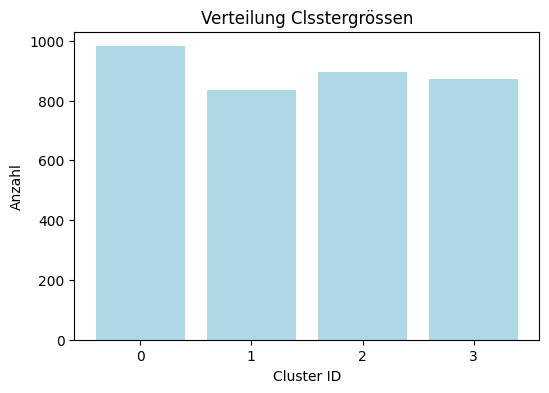

In [559]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.bar(cluster_counts["cluster"], cluster_counts["count"], color="lightblue")
plt.xlabel("Cluster ID")
plt.ylabel("Anzahl")
plt.title("Verteilung Clsstergrössen")
plt.xticks(cluster_counts["cluster"])
plt.show()


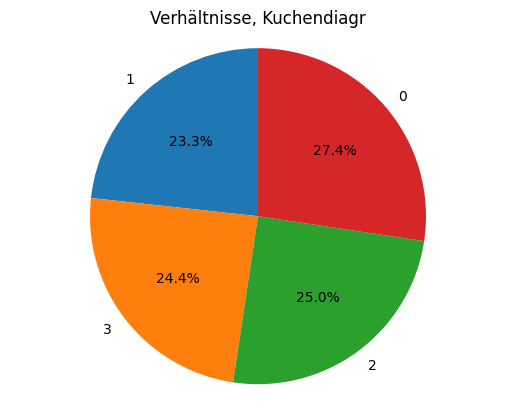

In [560]:
plt.pie(cluster_counts["count"], labels=cluster_counts["cluster"], autopct='%1.1f%%', startangle=90)
plt.title("Verhältnisse, Kuchendiagr")
plt.axis("equal")
plt.show()


Um jedoch zu verstehen, was wir hier eigentlich sehen und was die Cluster bedeuten, müssen wir uns näher damit auseinandersetzen.

In [561]:
df_timecluster.groupBy("cluster").avg("PM10", "PM2_5", "Ozon", "CO", "NO2", "NO", "Ozon_missing", "CO_missing", "NO_missing", "year_s", "month_s", "day_s", "weekday_s", "hour_s").show()
#zB können wir die durcschn Werte in einem Cluster ermitteln, um zu sehen, ob uns da etwas auffällt

+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+-----------------+-----------------+------------------+-----------+
|cluster|         avg(PM10)|        avg(PM2_5)|         avg(Ozon)|           avg(CO)|          avg(NO2)|           avg(NO)| avg(Ozon_missing)|    avg(CO_missing)|   avg(NO_missing)|       avg(year_s)|     avg(month_s)|       avg(day_s)|    avg(weekday_s)|avg(hour_s)|
+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+-----------------+-----------------+------------------+-----------+
|      1|10.740527567960662|10.614508407293178|  16.3001558912172|15.037302169296668| 23.40798561893207| 6.740839337130531|0.4784172661870504| 0.5215827338129496|0.4784172661870504|2022.0575539568

## Prognosen und künftige Entwicklungen
Wenn wir einen Blick in die Zukunft werfen und herausfinden wollen, welchen Wert es für eine bestimmte SPalte morgen geben wird, können wir das wie folgt:
<br>
Wir müssen uns für einen Ziel-Wert entscheiden. Den Ziel-Wert wollen wir schlussendlich dann vorhersagen können.
<br>
Da wir bereits unseren Feature-Vector haben, können wir direkt zum Schritt mit der Aufteilung von Test-Trainings-Daten gehen.

In [562]:
#Aufteilung der Daten in Trainings- und Test-Daten, in Prozent % 
train, test = df_timecluster.randomSplit([0.8, 0.2], seed=42)


In [563]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol="features_extended", labelCol="PM10")
model = lr.fit(train)
#wir wählen unser gesuchtes Feld labelCol und wenden linregression auf die Features an

In [564]:
predictions = model.transform(test)
predictions.select("PM10", "prediction").show(10)
#hier machen wir mal ein paar Vorhersagen und sehen, wie korrekt diese waren
#links in der TAbelle die tatscählichen Werte und rechts die vorhergesagten

+-----+------------------+
| PM10|        prediction|
+-----+------------------+
|10.88|13.333299927214284|
| 9.94|14.110501030169303|
|14.15| 17.26036373160889|
|16.96|16.149330116010105|
| 9.08|14.417816755892659|
|17.77|16.311032769953613|
|10.12| 16.67055102214681|
| 7.79|13.091328931449652|
|31.88|16.038836954777935|
|22.91| 15.86917315518508|
+-----+------------------+
only showing top 10 rows



In [565]:
#Unser Model können wir auch evaluieren
#Mit dem sog. root mean squared error, rmse, finden wir heraus, wie korrekt die Vorhersagen sind
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol="PM10", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"RMSE: {rmse}")
#beim rmse gilt: je kleiner desto besser

RMSE: 6.646636083341371


Mehr zu Evaluationsmethoden und dem RMSE finden sich hier: https://spark.apache.org/docs/4.0.0/mllib-evaluation-metrics.html
<br>
Mit dem RMSE können generell Regressionsmodelle evaluiert werden.Damit wird die Unterschiedsgrösse von vorhergesagten und tatsächlichen Werten berechnet (grosse Unterschiede werden bestraft bzw. der RMSE reagiert stark auf Outliers).
<br>
Der RMSE ist immer positiv und ein Wert von 0 würde heissen, dass das Modell perfekte Predictions liefert. Im Allgemeinen gilt, dass ein niedriger RMSE besser ist.
<br>
Weiteres auch auf Wikipedia: https://en.wikipedia.org/wiki/Root_mean_square_deviation
<br>


### Fehlende WErte vorhersagen
Ein für uns potenziell interessanter CAse wäre das ERmitteln und VOrhesagen von fehlenden Werten. Diese werden vielleicht durch äussere Einflüsse (Wetterphänomene) oder durch internes Versagen (Sensor versagt, kaputt usw.) verursacht.
<br>
Wir suchen usn daher als Zielwert einen aus, der dafür bekannt ist, NULL-Werte zu produzieren. Aus diesem Grund haben wir drei _missing-COlumns erstellt, an denen wir uns auch hierzu orientieren können.
<br>
Resltat soll also eine Vorhersage darüber sein, ob der besagte Wert wieder NULL seinw ird oder nicht.

In [566]:
target_col = "CO_missing" #hier definieren wir die gesuchte Spalte, diese enthält 1 oder 0 als Werte zur Aussage darüber, ob es in der eigentlichen Spalte dazu Inhalte gab
train, test = df_timecluster.randomSplit([0.8, 0.2], seed=42) #wir teilen wieder in Test Trianign auf

In [567]:
from pyspark.ml.classification import RandomForestClassifier

#wir verwenden randomforest und bauen uns in diesem Fall, numtree, 50 Entscheidungsbäume


rf = RandomForestClassifier(labelCol="CO_missing", featuresCol="features_extended", predictionCol="predicted", numTrees=50)
model = rf.fit(train)


In [568]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

predictions = model.transform(test)

#wir evaluieren das Model
#die Resultate bedeuten:
#0.5 = willkürliches Raten
#1 = perfekte Vorhersage

evaluator = BinaryClassificationEvaluator(labelCol="CO_missing", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
roc_auc = evaluator.evaluate(predictions)
print(f"ROC AUC = {roc_auc:.3f}")


ROC AUC = 0.629


In [569]:
import pandas as pd

#wir können uns auch ansehen, welche Features das Model hauptsächlich berücksichtigt hat
#eine hohe Wichtigkeit deutet also daraufhin, dass es einen grossen Einfluss auf das Fehlen des Features hat
#das kann also eine Aussage darüber ermöglichen, wieso zB der Sensor ausfällt

imp = model.featureImportances
feature_importance = pd.DataFrame({
    "feature": extended_cols,
    "importance": imp.toArray()
}).sort_values("importance", ascending=False)
print(feature_importance)


                                             feature  importance
7                Wind speed scalar daily mean in m/s    0.267618
6  Relative air humidity 2 m above ground daily mean    0.228010
5        Air temperature 2 m above ground daily mean    0.194806
8            Precipitation daily total 0 UTC - 0 UTC    0.134373
1                                            month_s    0.067387
2                                              day_s    0.053036
0                                             year_s    0.030076
3                                          weekday_s    0.024695
4                                             hour_s    0.000000


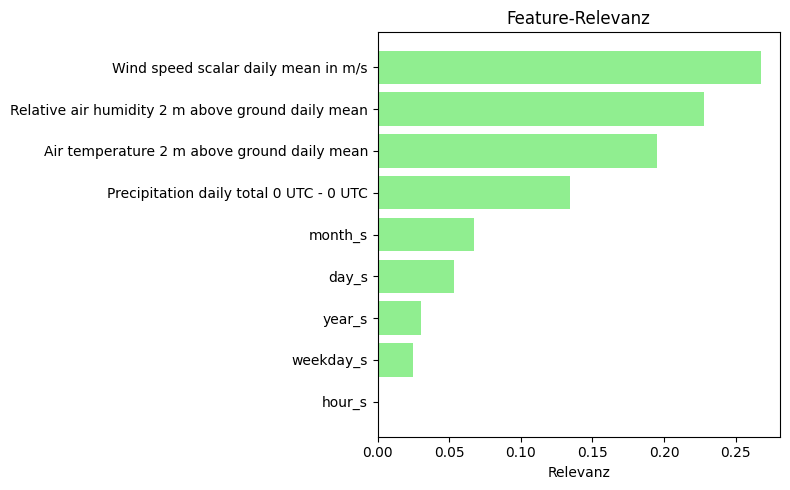

In [570]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.barh(feature_importance["feature"], feature_importance["importance"], color="lightgreen")
plt.gca().invert_yaxis()
plt.title("Feature-Relevanz")
plt.xlabel("Relevanz")
plt.tight_layout()
plt.show()

#das Ganze können wir auch noch visualisieren, um die Interpretation ggf zu vereinfachen

### Fenster als zeitlicher Fokus
Fenster erlauben es, einfacher Trends und Muster zu erkennen, da es einfacher wird, diese zu vergleichen.

In [571]:
from pyspark.sql.functions import avg
from pyspark.sql.window import Window

window_spec = Window.orderBy("date").rowsBetween(-2, 0)

df_timecluster_windows = df_timecluster.withColumn("PM10_3hr_avg", avg("PM10").over(window_spec))

#so haben wir ein kurzfristige PM10-Trend-Auswertung
#avg ist nicht Pflicht, man kann dasselbe auch mit anderen Metriken wie min, max, sum, rank, usw machen


In [572]:
df_timecluster_windows.dtypes

[('date', 'string'),
 ('location', 'string'),
 ('PM10', 'float'),
 ('PM2_5', 'float'),
 ('Ozon', 'float'),
 ('CO', 'float'),
 ('NO2', 'float'),
 ('NO', 'float'),
 ('Air temperature 2 m above ground daily mean', 'float'),
 ('Air temperature 2 m above ground daily maximum', 'string'),
 ('Air temperature 2 m above ground daily minimum', 'string'),
 ('Air temperature at 5 cm above grass daily mean', 'string'),
 ('Air temperature at 5 cm above grass daily maximum', 'string'),
 ('Air temperature at 5 cm above grass daily minimum', 'string'),
 ('Relative air humidity 2 m above ground daily mean', 'float'),
 ('Vapour pressure 2 m above ground daily mean', 'string'),
 ('Atmospheric pressure at barometric altitude (QFE) daily mean', 'string'),
 ('Pressure reduced to sea level (QFF) daily mean', 'string'),
 ('Geopotential height of the 850 hPA level daily mean', 'string'),
 ('Geopotential height of the 700 hPA level daily mean', 'string'),
 ('Pressure reduced to sea level according to standard at

In [573]:
df_save = df_timecluster_windows.toPandas()

df_save.to_csv("data/ML/ML_Data.csv", index=False)

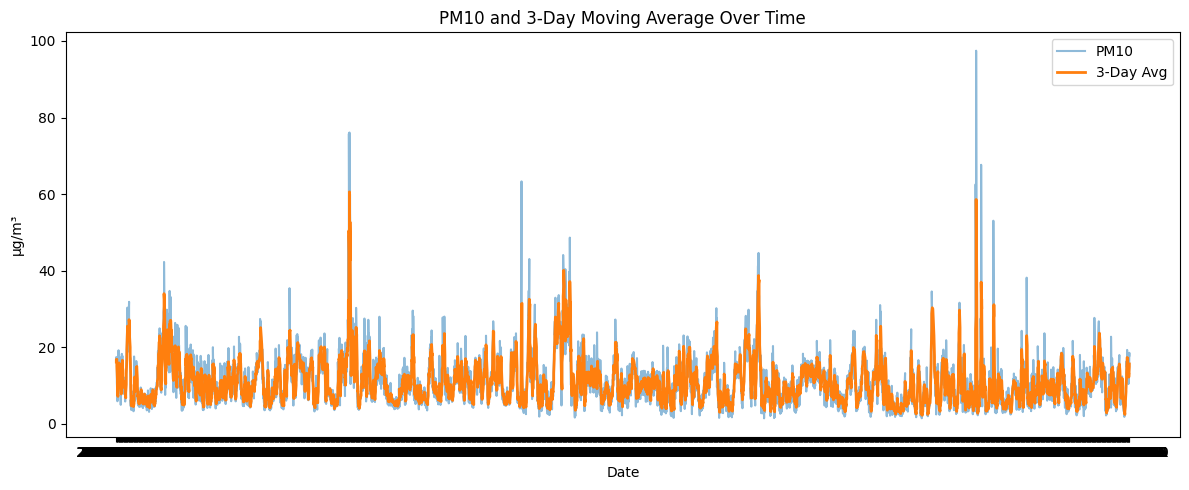

In [574]:
#Visualisierung hilft beim ERkennen von zB spontnane Ausreissern, rhytmischen zeitlichen Mustern, Outliern usw
import matplotlib.pyplot as plt
from pyspark.sql.functions import date_format

df_selected = df_timecluster_windows.select(
    "date","PM10", "PM10_3hr_avg"
)


df_plot = df_selected.toPandas()




plt.figure(figsize=(12, 5))
plt.plot(df_plot["date"], df_plot["PM10"], label="PM10", alpha=0.5)
plt.plot(df_plot["date"], df_plot["PM10_3hr_avg"], label="3-Day Avg", linewidth=2)
plt.legend()
plt.title("PM10 and 3-Day Moving Average Over Time")
plt.xlabel("Date")
plt.ylabel("µg/m³")
plt.tight_layout()
plt.show()
